In [2]:
import pandas as pd
import numpy as np
from data_process import *
from metadata import *
import matplotlib.pyplot as plt
import plotly.express as px
import cufflinks as cf
from plotly.offline import plot, iplot, download_plotlyjs, init_notebook_mode
import seaborn as sns

In [16]:
init_notebook_mode(connected=True)
cf.go_offline()

In [17]:
def toss_win_to_win_count():
    """
    Return the Dataframe with match win to toss win percentage
    """
    toss_match_df = season_summary_df[['toss_won', 'winner']].dropna()
    toss_match_df['win'] = toss_match_df['toss_won'] == toss_match_df['winner']
    toss_match_df['win'] = toss_match_df['win'].astype(int)
    
    toss_match_df['toss'] = 1
    toss_match_df = toss_match_df.groupby(['winner']).sum().reset_index() 
    toss_match_df['toss_win_percentage'] = toss_match_df['win']*100/toss_match_df['toss']
    
    toss_match_df = toss_match_df[toss_match_df['winner'] != 'No Result']
    return toss_match_df
    

toss_win_to_win_count().iplot(kind='bar', x='winner', y='toss_win_percentage', title='Toss Win to Win Percentage',  barmode = 'group')
    

In [18]:
def ground_toss_decision():
    """
    This function will return the dataframe for every ground % of BAT FIRST and BOWL FIRST
    """
    venue_toss_df = season_summary_df[['venue_id','venue_name', 'decision']].dropna()
    venue_toss_df['bat_first'] = venue_toss_df['decision'].str.contains('BAT').astype(int)
    venue_toss_df['toss'] = 1
    venue_toss_df = venue_toss_df.groupby(['venue_id', 'venue_name']).sum().reset_index()
    venue_toss_df['bat_first_percentage'] = venue_toss_df['bat_first']*100/venue_toss_df['toss']
    venue_toss_df['bowl_first_percentage'] = 100 - venue_toss_df['bat_first_percentage']
    return venue_toss_df

ground_toss_decision().iplot(kind='barh', x='venue_name', y=['bat_first_percentage','bowl_first_percentage'], title='Ground Toss Decision', size=10)
    

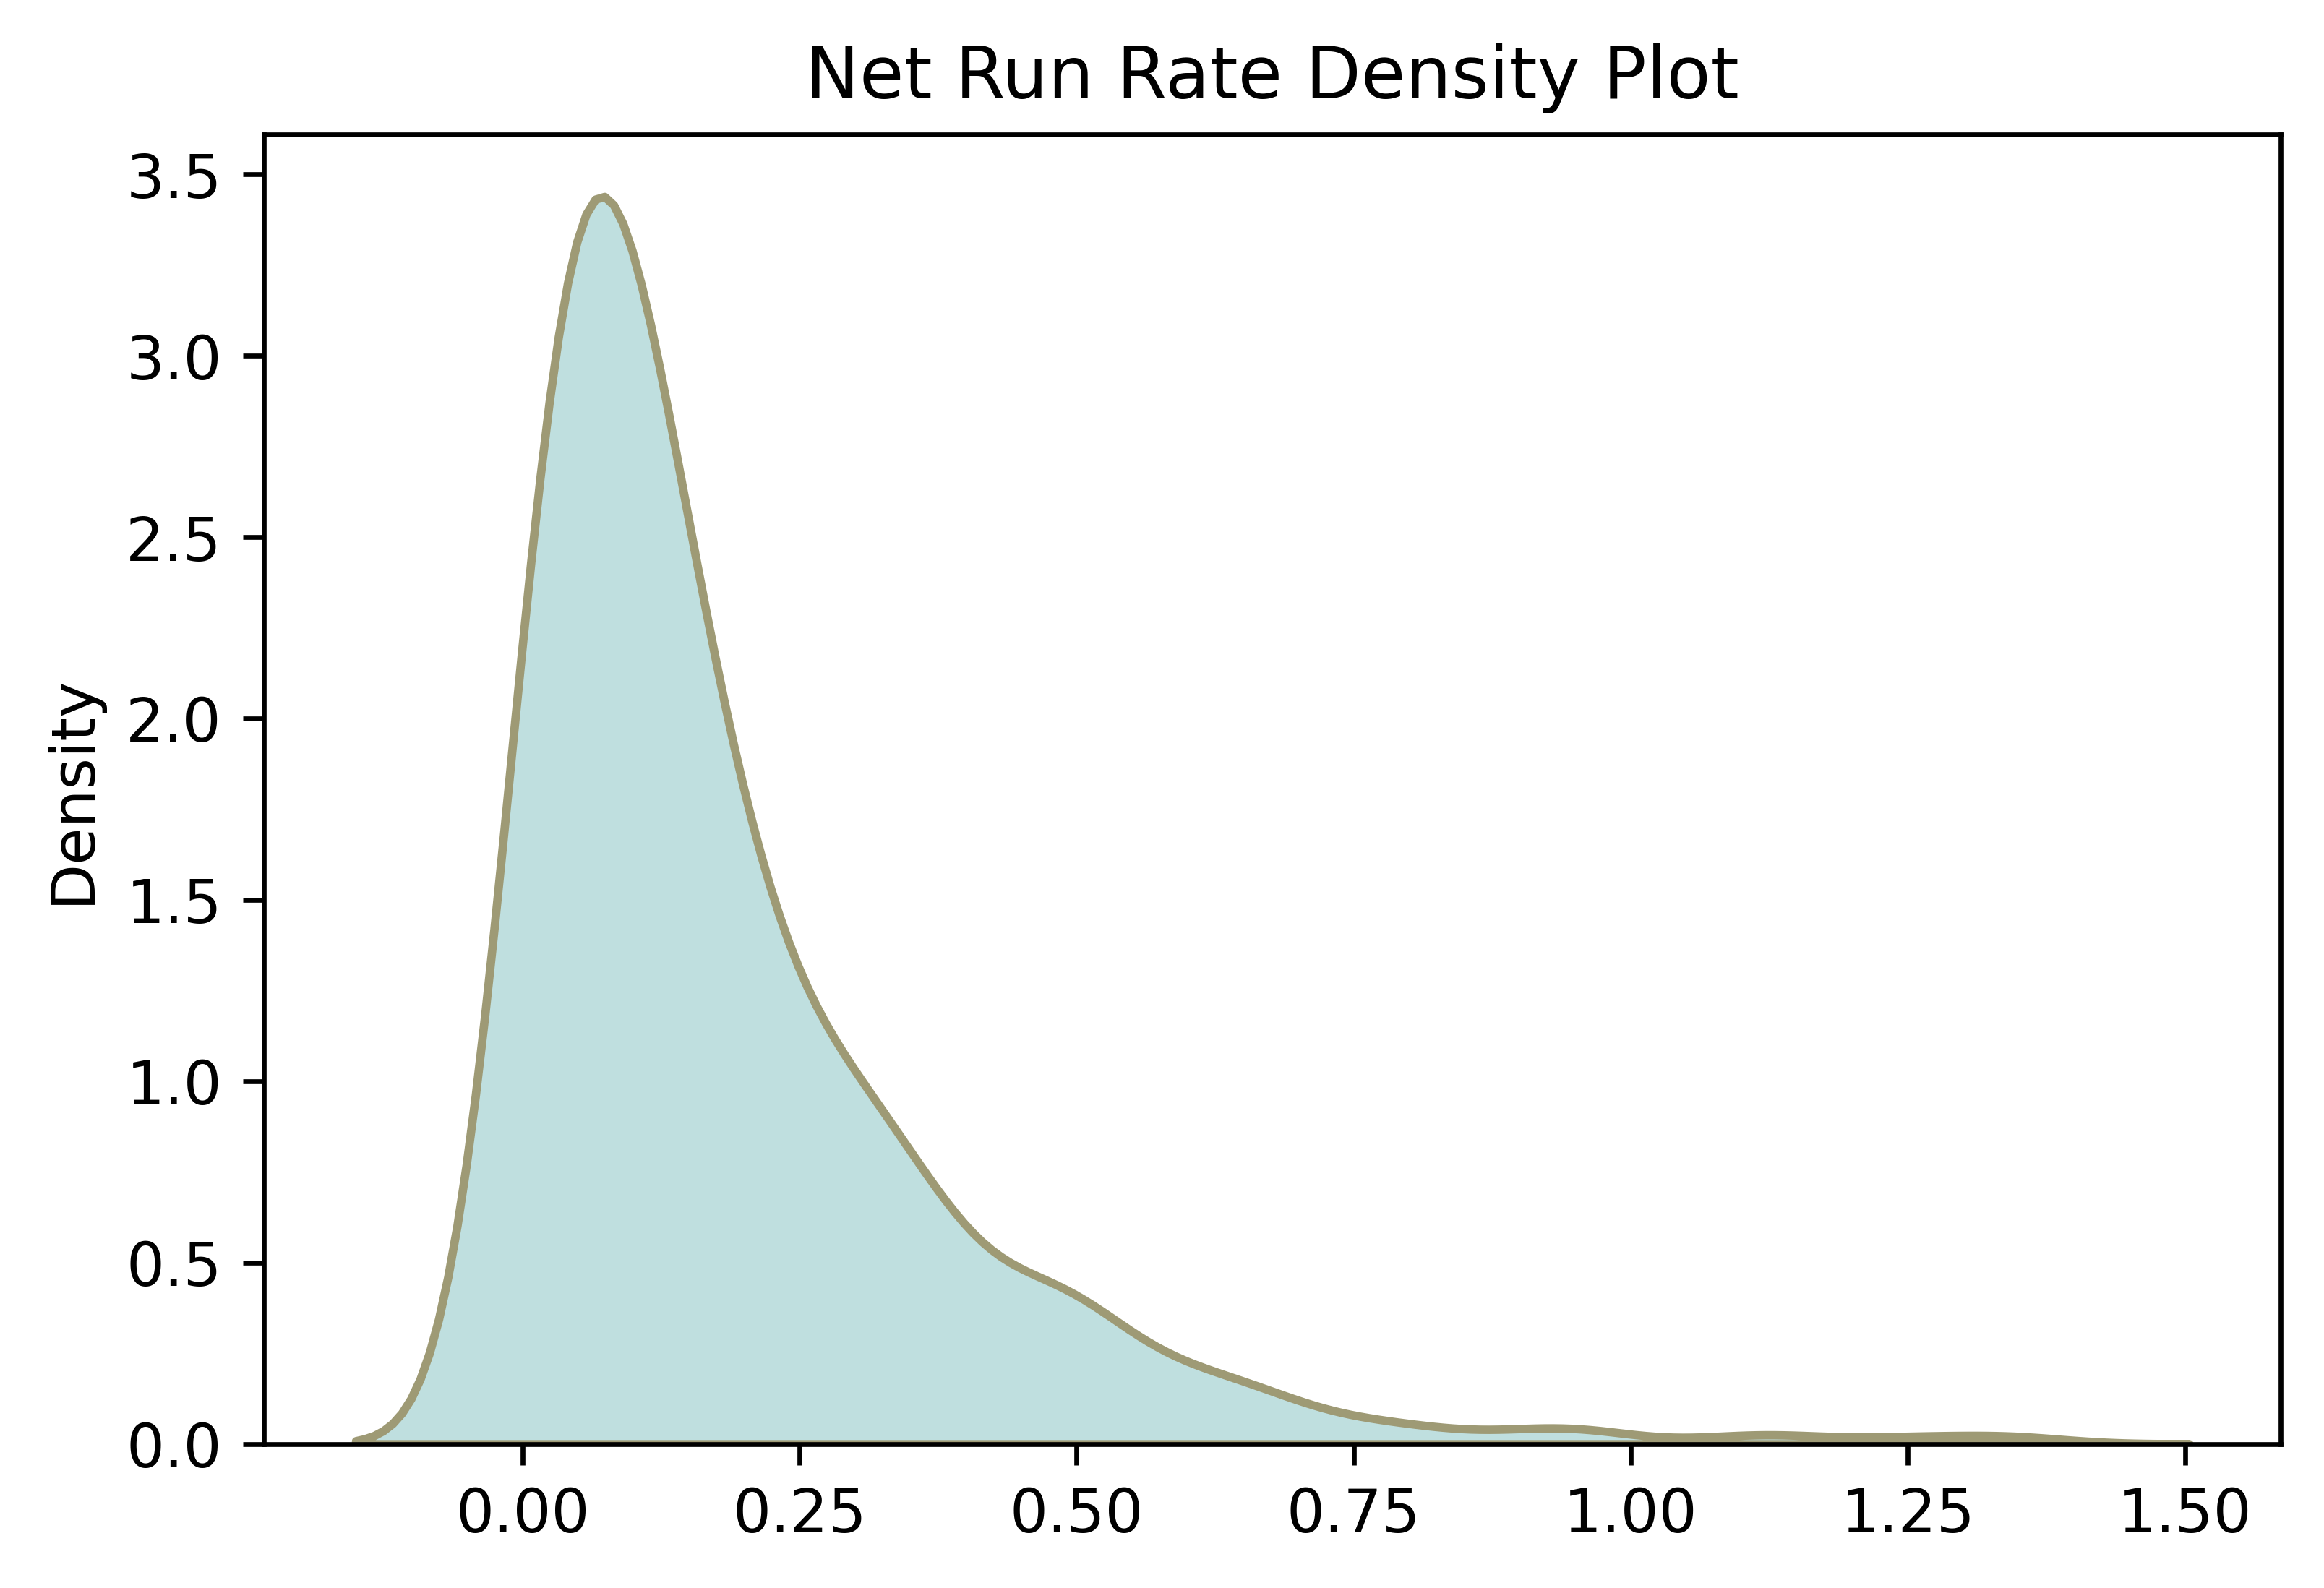

In [19]:
# Density Plot of Net Run Rate

# over to balls
def over_to_balls(over):
    over = str(over)
    ov = int(over.split('.')[0])
    balls = int(over.split('.')[1])
    return ov*6 + balls


def net_run_rate_density():
    """
    This function will return the density plot of net run rate
    """
    net_run_rate_df = season_summary_df[['away_runs', 'away_overs', 'home_overs', 'home_runs']].dropna()
    net_run_rate_df['home_balls'] = net_run_rate_df['home_overs'].map(lambda x: over_to_balls(x))
    net_run_rate_df['away_balls'] = net_run_rate_df['away_overs'].map(lambda x: over_to_balls(x))
    net_run_rate_df['nrr1'] = net_run_rate_df['home_runs']/net_run_rate_df['home_balls'] - net_run_rate_df['away_runs']/net_run_rate_df['away_balls']
    net_run_rate_df['nrr2'] = -1*net_run_rate_df['nrr1']
    nrr = list(net_run_rate_df['nrr1']) + list(net_run_rate_df['nrr2'])
    nrr = [i for i in nrr if i >= 0]
    nrr = np.array(nrr)
    sns.kdeplot(nrr, shade=True, color='#008080', fill=True, lw=1.4, edgecolor='#9e9a75')
    plt.title("Net Run Rate Density Plot")

net_run_rate_density()


In [20]:
# team with highest net run rate
def team_with_highest_avg_net_run_rate():
    net_run_rate_df = season_summary_df[['away_runs', 'away_overs', 'home_overs', 'home_runs','home_team','away_team']].dropna()
    net_run_rate_df['home_balls'] = net_run_rate_df['home_overs'].map(lambda x: over_to_balls(x))
    net_run_rate_df['away_balls'] = net_run_rate_df['away_overs'].map(lambda x: over_to_balls(x))
    net_run_rate_df['home_nrr'] = net_run_rate_df['home_runs']/net_run_rate_df['home_balls'] - net_run_rate_df['away_runs']/net_run_rate_df['away_balls']
    net_run_rate_df['away_nrr'] = -1*net_run_rate_df['home_nrr']
    home_df = net_run_rate_df[['home_team','home_nrr']]
    home_df.columns = ['team', 'nrr']
    away_df = net_run_rate_df[['away_team','away_nrr']]
    away_df.columns = ['team', 'nrr']
    nrr_df = pd.concat([home_df, away_df])
    nrr_df['matches'] = 1
    nrr_df = nrr_df.groupby(['team']).sum().reset_index()
    nrr_df['avg_nrr'] = nrr_df['nrr']/nrr_df['matches']
    nrr_df = nrr_df.sort_values(by='avg_nrr', ascending=False)
    nrr_df = nrr_df.reset_index(drop=True)
    return nrr_df

team_with_highest_avg_net_run_rate().iplot(kind='bar', x='team', y='avg_nrr', title='Team with highest net run rate', barmode='group')


/tmp/ipykernel_5074/3190163550.py:30: UserWarning:

FixedFormatter should only be used together with FixedLocator



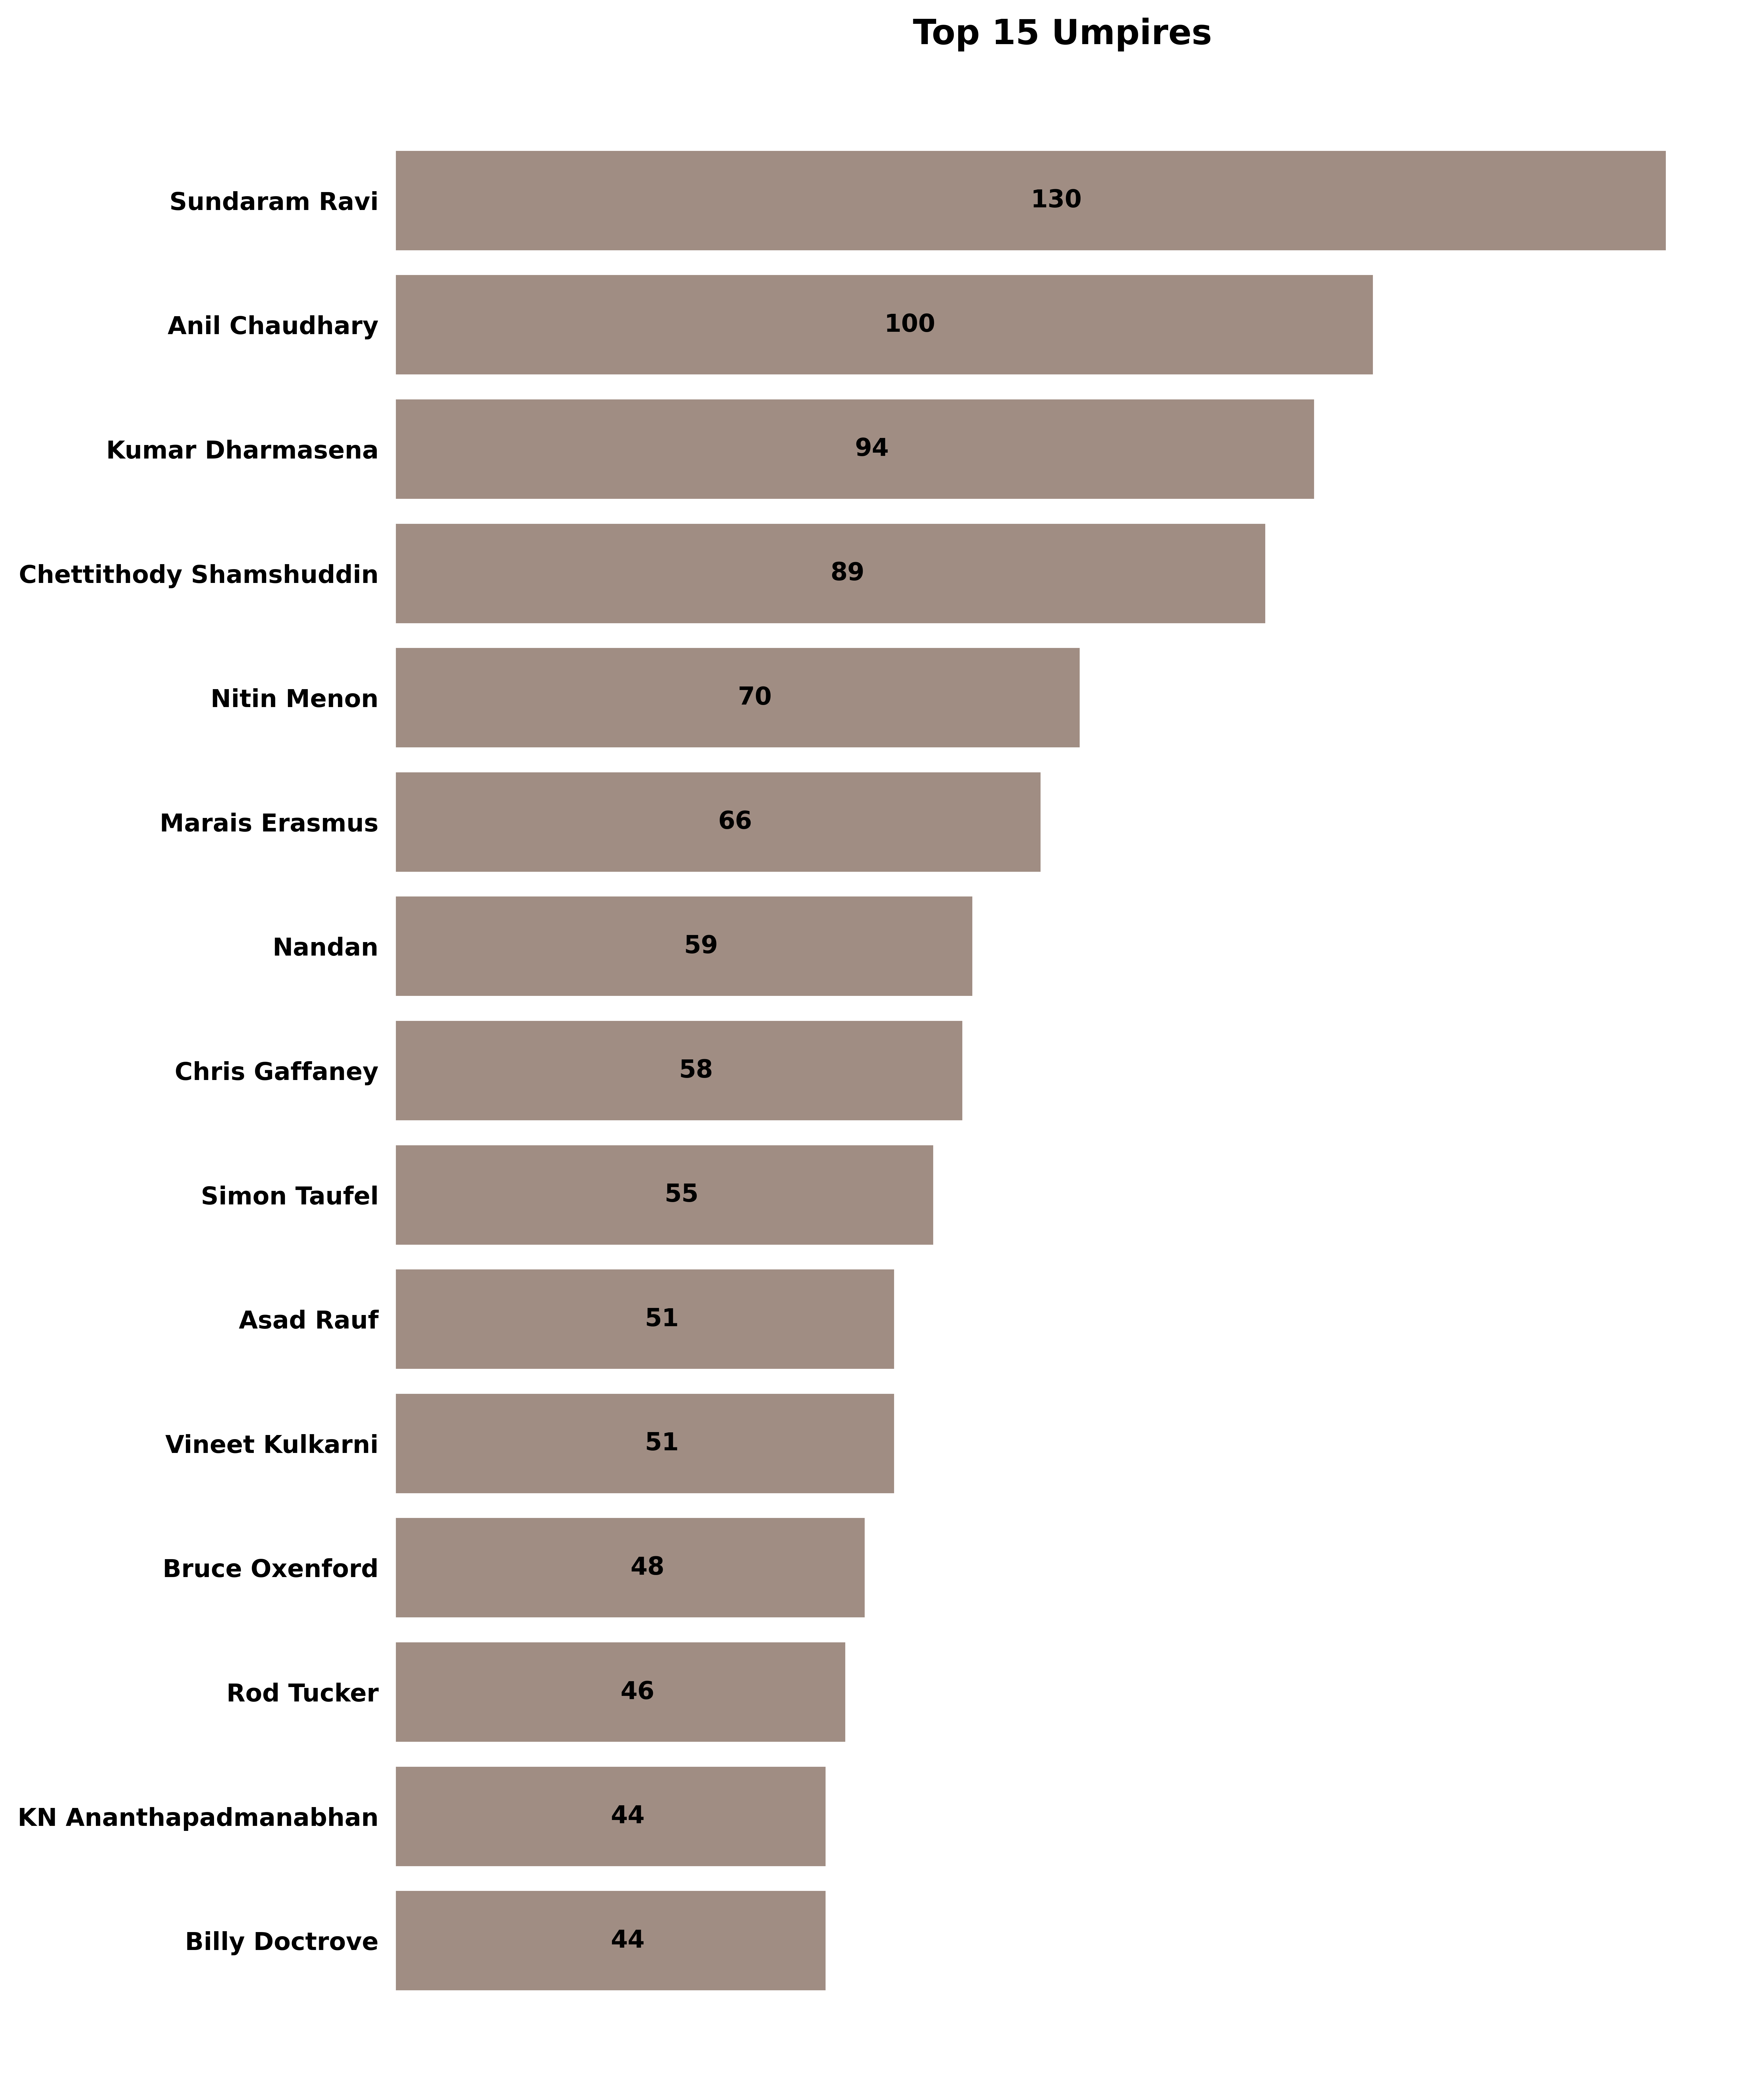

In [21]:
def top_umpires():
    umpires = season_summary_df[['umpire1','umpire2']].dropna()
    umpires['matches'] = 1
    umpires1 = umpires[['umpire1','matches']]
    umpires1.columns = ['umpire', 'matches']
    umpires2 = umpires[['umpire2','matches']]
    umpires2.columns = ['umpire', 'matches']
    umpires_df = pd.concat([umpires1, umpires2])
    umpires_df = umpires_df.groupby(['umpire']).sum().reset_index()
    umpires_df = umpires_df.sort_values(by='matches', ascending=False)
    umpires_df = umpires_df.reset_index(drop=True)
    # select top 10
    umpires_df = umpires_df.head(15)
    umpires_df = umpires_df.sort_values(by='matches', ascending=True)

    
    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    fig = plt.figure(figsize=(10, 12), facecolor='#ffffff')

    gs = fig.add_gridspec(1,1)
    gs.update(wspace=0.3, hspace=0.4)

    locals()["ax"+str(0)] = fig.add_subplot(gs[0, 0])
    locals()["ax"+str(0)].set_facecolor(background_color)
    for s in ['left', 'right', 'top', 'bottom']:
        locals()["ax"+str(0)].spines[s].set_visible(False)

    locals()["ax"+str(0)].barh(y = umpires_df['umpire'], width= umpires_df['matches'], label='matches', color='#A08D83')
    locals()["ax"+str(0)].set_yticklabels(umpires_df['umpire'], fontsize=10, fontweight='bold')
    locals()["ax"+str(0)].set_title('Top 15 Umpires',fontsize=14, fontweight='bold')
    for s in ['left', 'right', 'top', 'bottom']:
        locals()["ax"+str(0)].spines[s].set_visible(False)

    locals()["ax"+str(0)].xaxis.set_visible(False) 
    locals()["ax"+str(0)].tick_params(left=False)

    for p in locals()["ax"+str(0)].patches:
        value = f'{round(p.get_width(),0)}'        
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() / 2 
        locals()["ax"+str(0)].text(x, y, value, ha='left', va='center', fontsize=10, color='black',fontweight='bold')
            
    gs.tight_layout(fig, rect=[0, 0, 1, 1])
    plt.show()

top_umpires()

<ipython-input-3-046e8723c09b>:39: UserWarning:

FixedFormatter should only be used together with FixedLocator



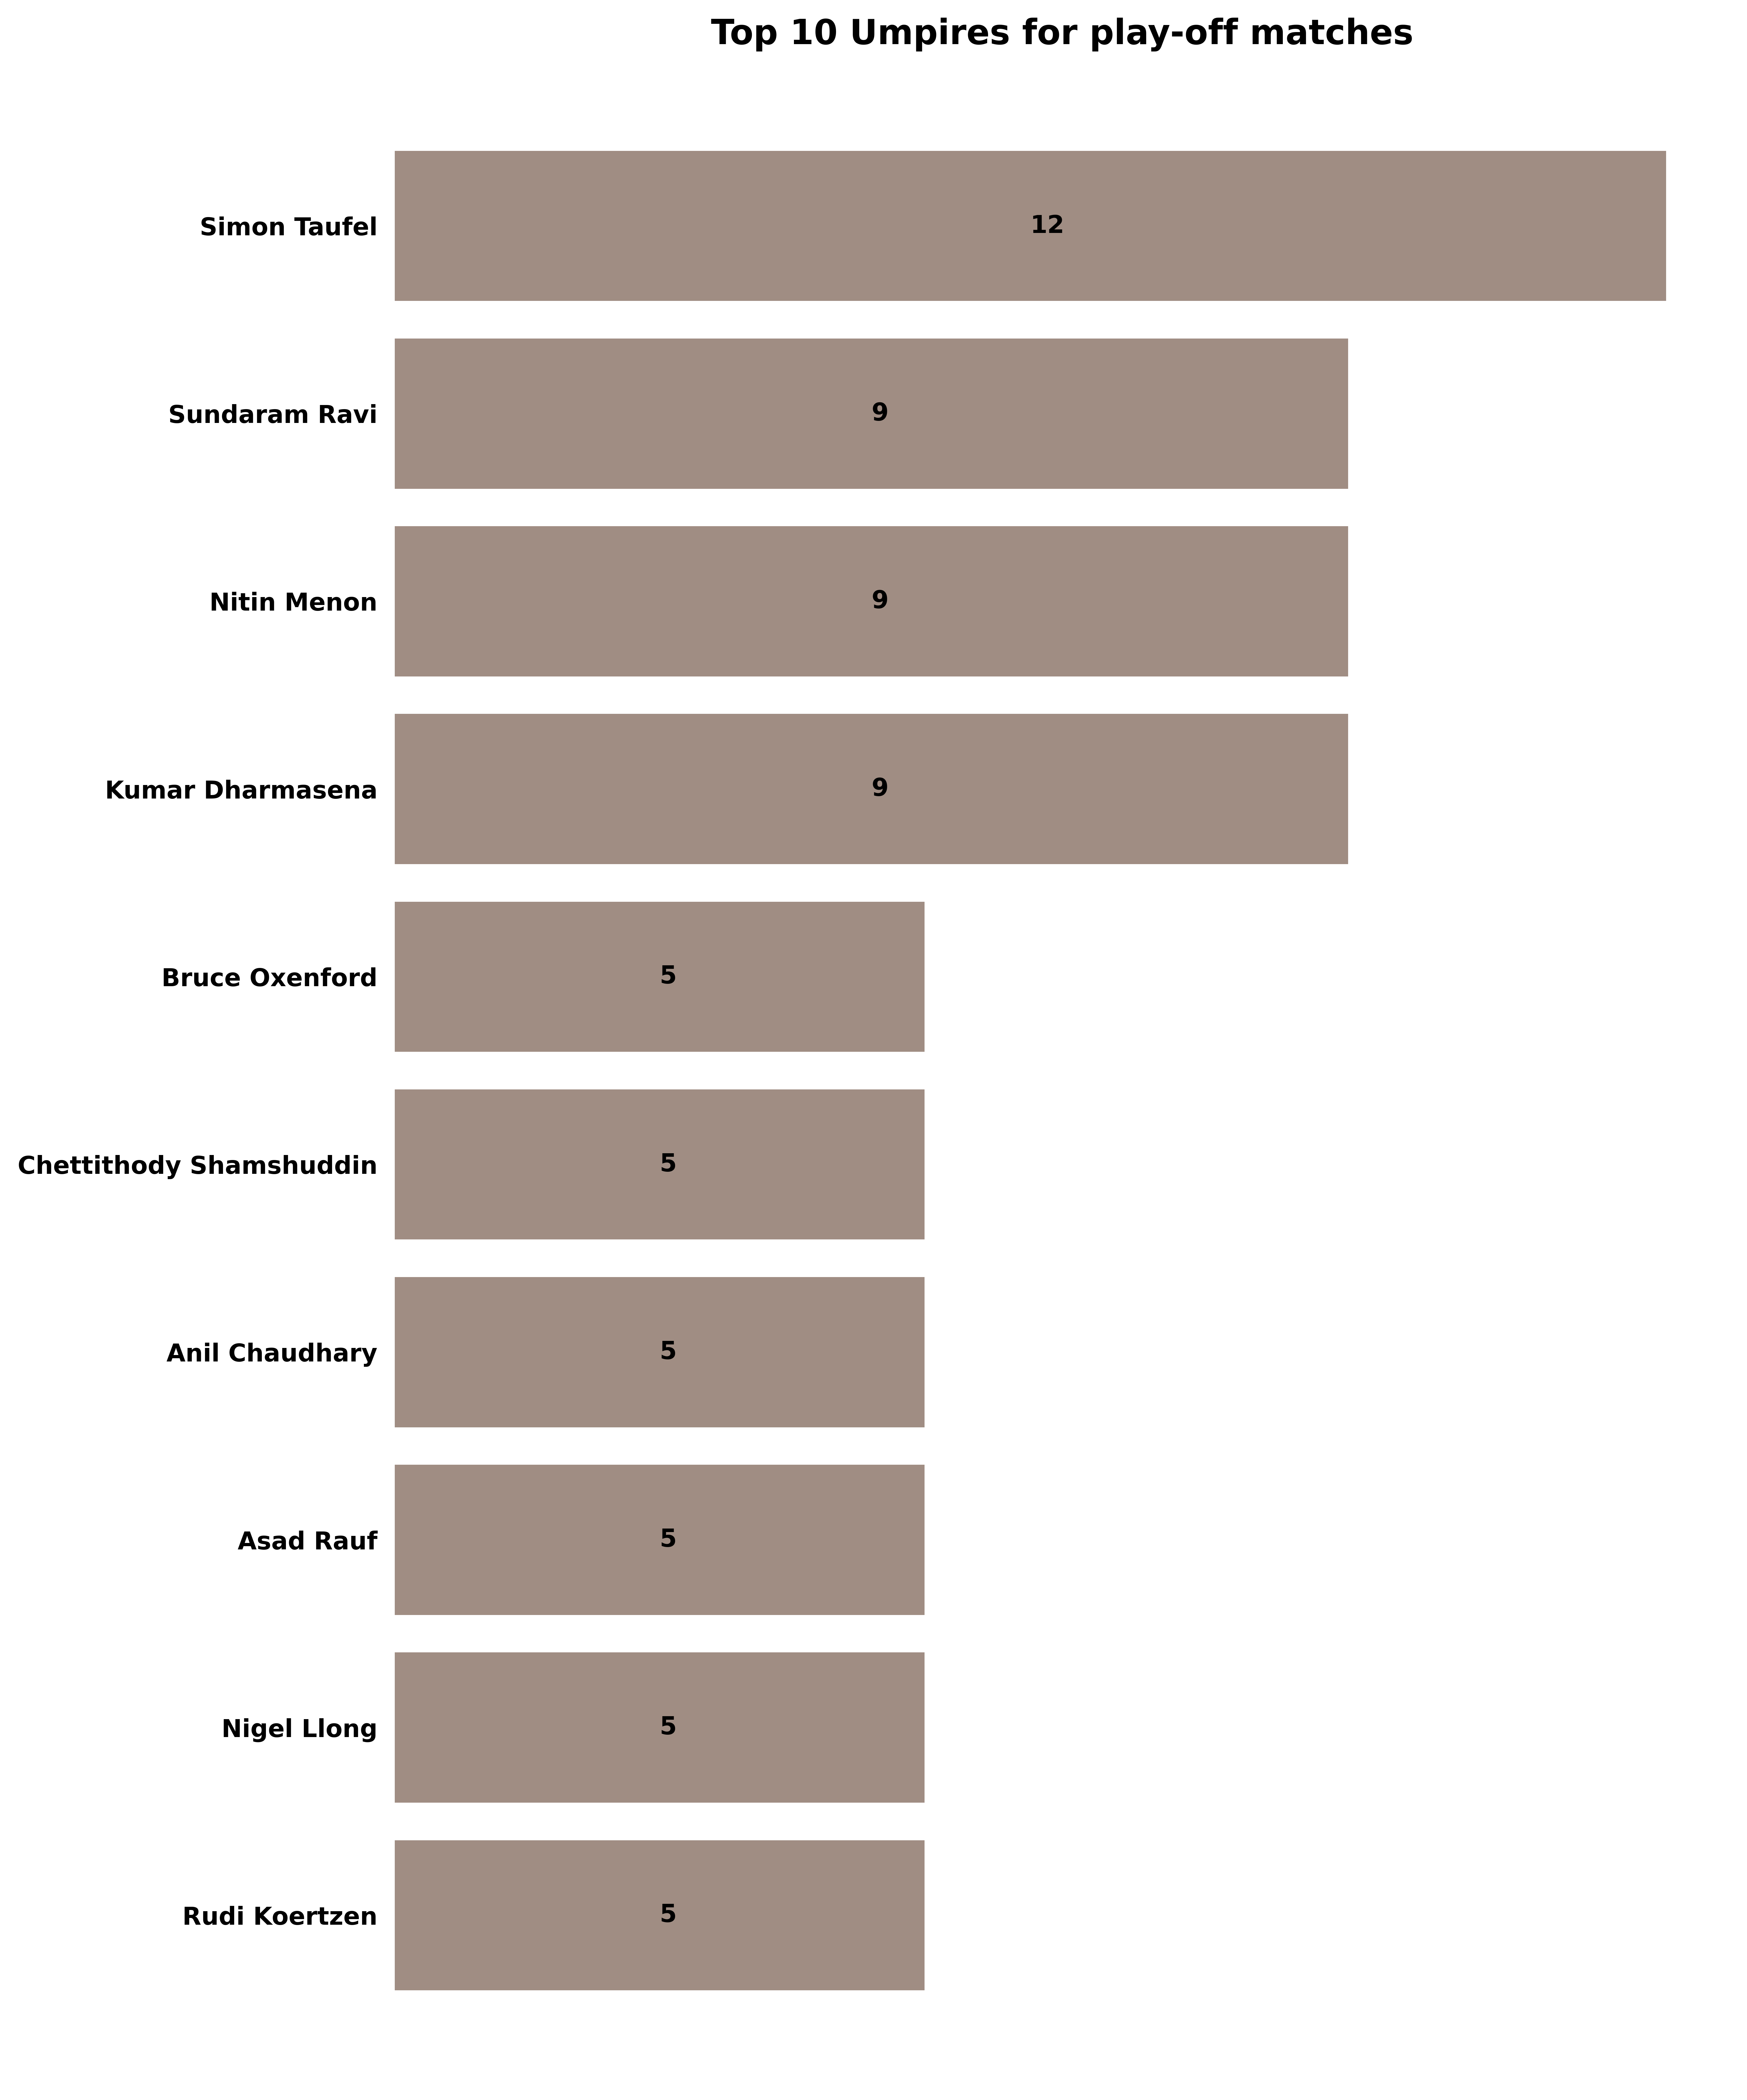

In [3]:
def popular_umpire_playoff():
    def is_playoff(desc):
        stage = ['Play-Off', 'Eliminator', 'Final', 'Semi-Final','Qualifier', 'Qualifying']
        for i in stage:
            if i in desc:
                return True
        return False

    umpires = season_summary_df[['umpire1','umpire2','description']].dropna()
    umpires['isplayoff'] = umpires['description'].map(lambda x: is_playoff(x))
    umpires = umpires[umpires['isplayoff'] == True]
    umpires['matches'] = 1
    umpires1 = umpires[['umpire1','matches']]
    umpires1.columns = ['umpire', 'matches']
    umpires2 = umpires[['umpire2','matches']]
    umpires2.columns = ['umpire', 'matches']
    umpires_df = pd.concat([umpires1, umpires2])
    umpires_df = umpires_df.groupby(['umpire']).sum().reset_index()
    umpires_df = umpires_df.sort_values(by='matches', ascending=False)
    umpires_df = umpires_df.reset_index(drop=True)
    # select top 10
    umpires_df = umpires_df.head(10)
    umpires_df = umpires_df.sort_values(by='matches', ascending=True)

    
    plt.rcParams['figure.dpi'] = 600
    background_color = '#ffffff'
    fig = plt.figure(figsize=(10, 12), facecolor='#ffffff')

    gs = fig.add_gridspec(1,1)
    gs.update(wspace=0.3, hspace=0.4)

    locals()["ax"+str(0)] = fig.add_subplot(gs[0, 0])
    locals()["ax"+str(0)].set_facecolor(background_color)
    for s in ['left', 'right', 'top', 'bottom']:
        locals()["ax"+str(0)].spines[s].set_visible(False)

    locals()["ax"+str(0)].barh(y = umpires_df['umpire'], width= umpires_df['matches'], label='matches', color='#A08D83')
    locals()["ax"+str(0)].set_yticklabels(umpires_df['umpire'], fontsize=10, fontweight='bold')
    locals()["ax"+str(0)].set_title('Top 10 Umpires for play-off matches',fontsize=14, fontweight='bold')
    for s in ['left', 'right', 'top', 'bottom']:
        locals()["ax"+str(0)].spines[s].set_visible(False)

    locals()["ax"+str(0)].xaxis.set_visible(False) 
    locals()["ax"+str(0)].tick_params(left=False)

    for p in locals()["ax"+str(0)].patches:
        value = f'{round(p.get_width(),0)}'        
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() / 2 
        locals()["ax"+str(0)].text(x, y, value, ha='left', va='center', fontsize=10, color='black',fontweight='bold')
            
    gs.tight_layout(fig, rect=[0, 0, 1, 1])
    plt.show()

popular_umpire_playoff()

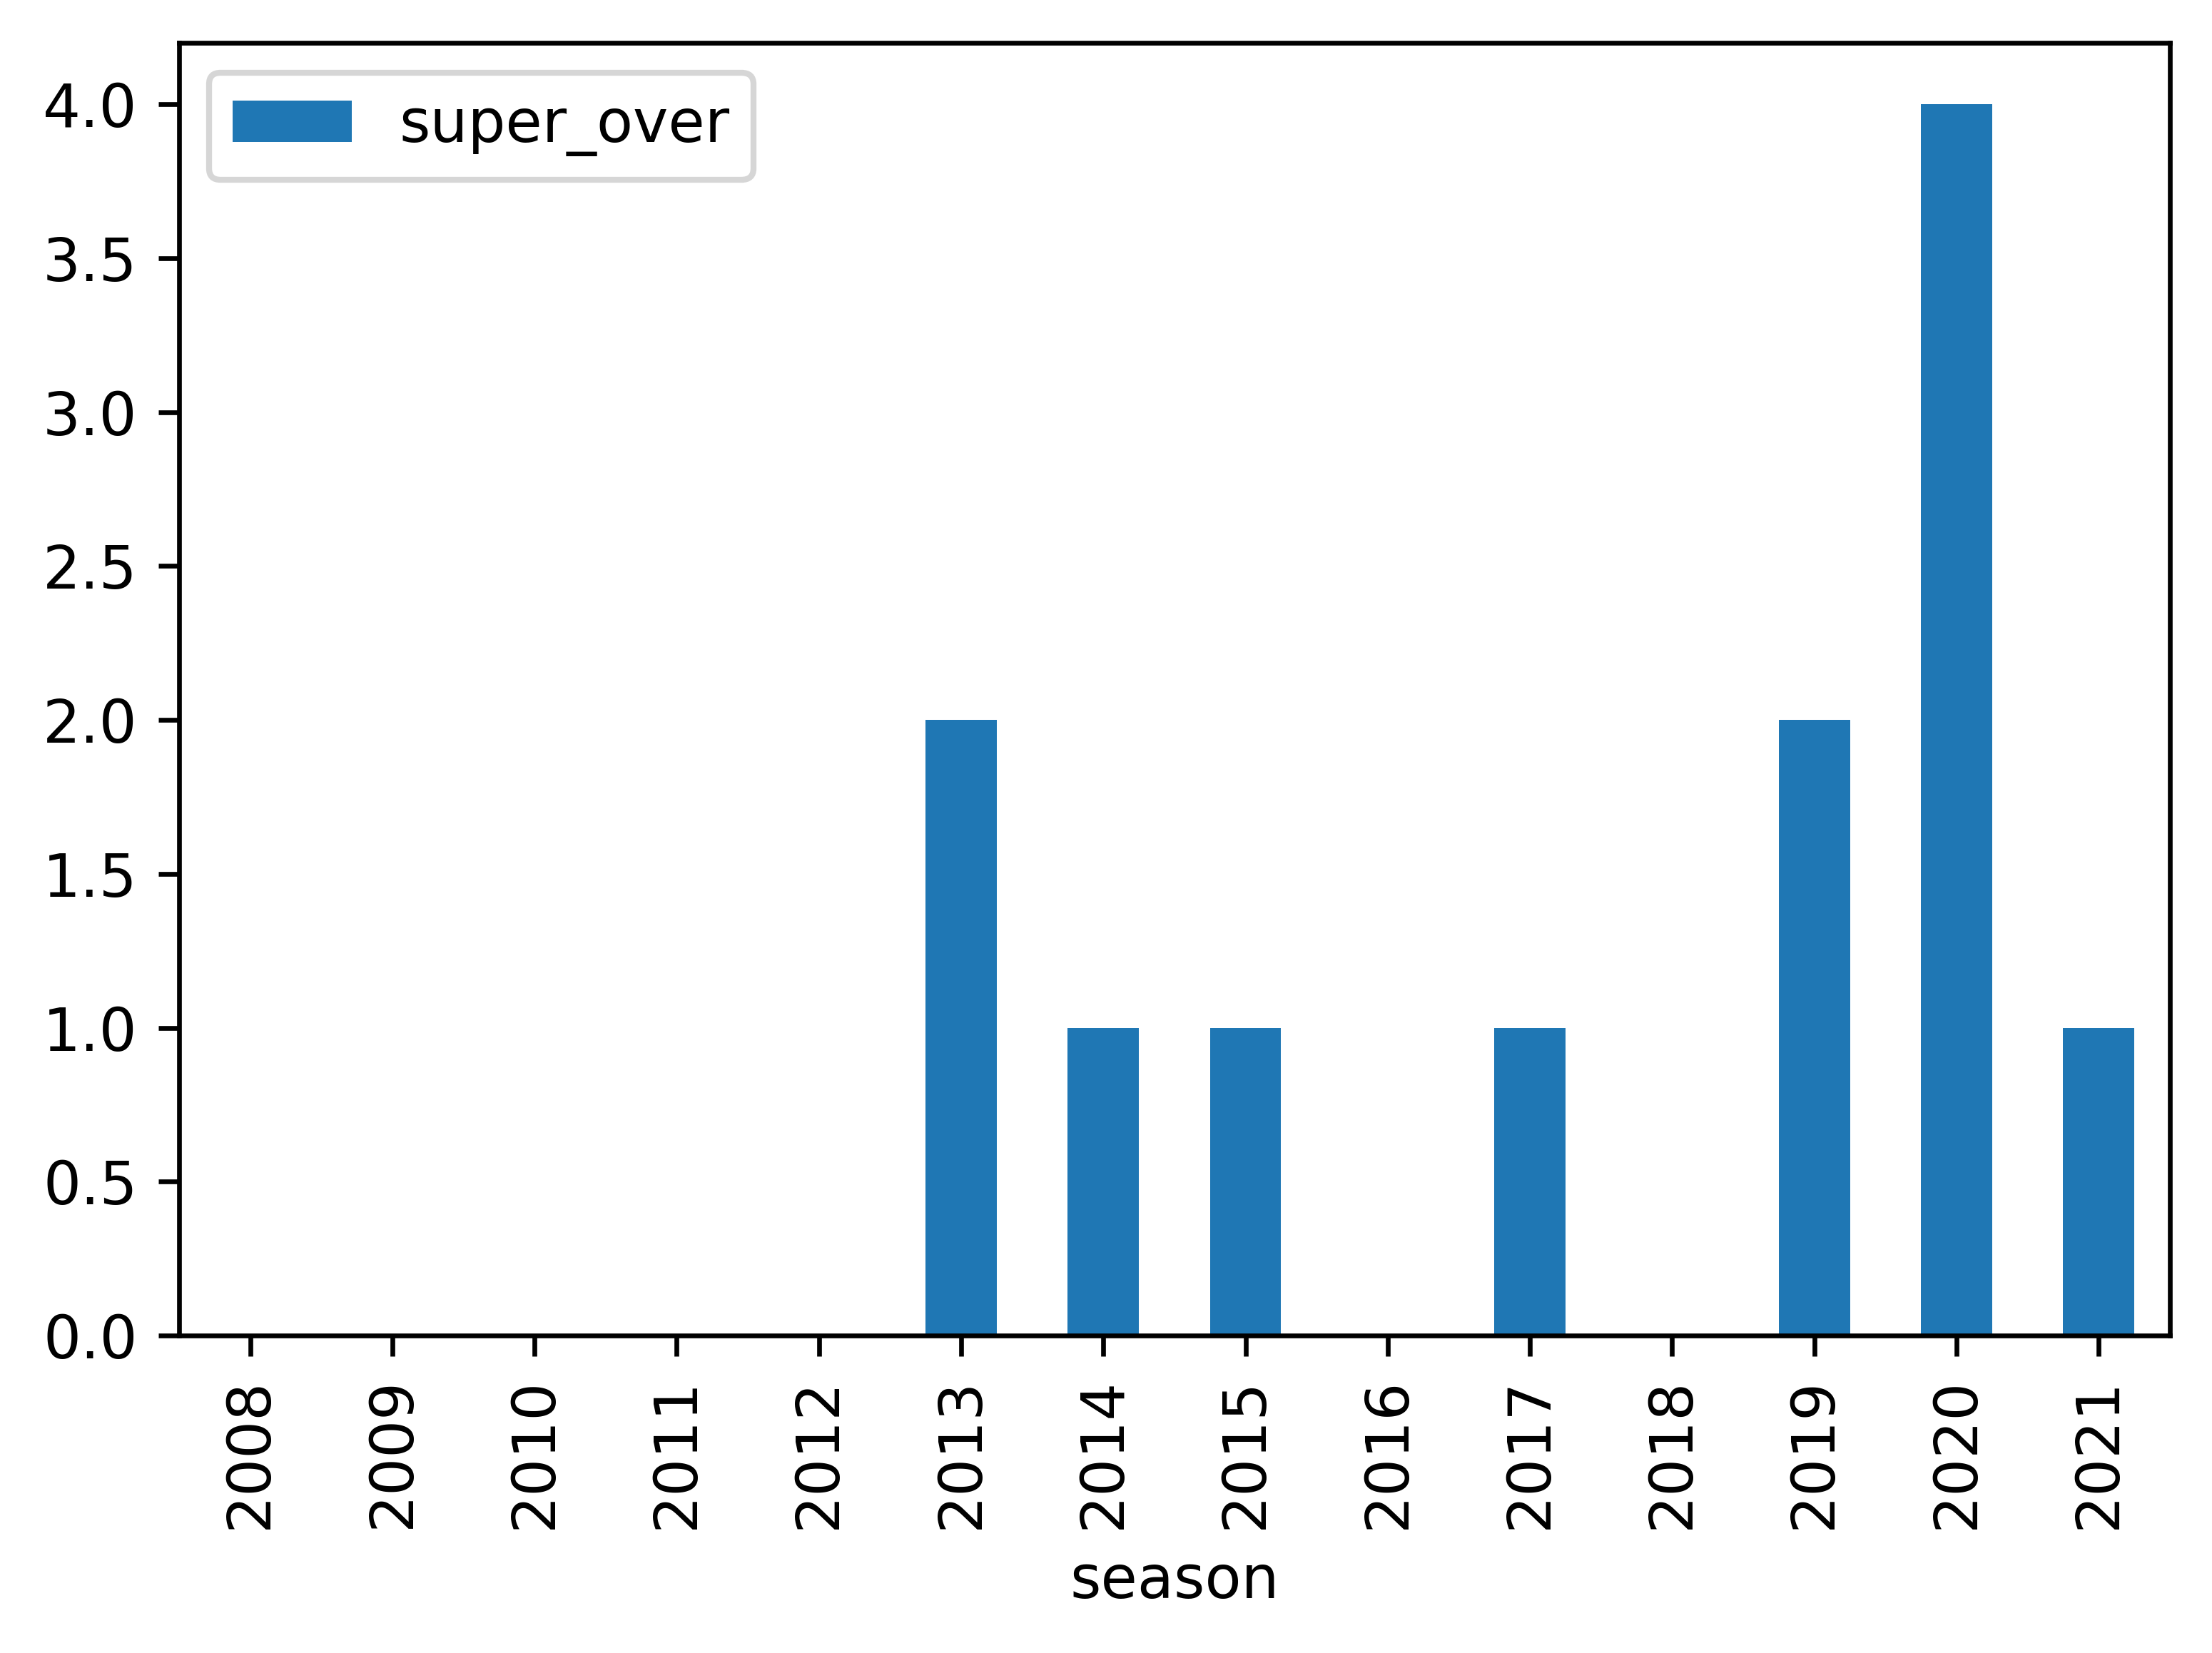

In [22]:
def super_over():
    super_over = season_summary_df[['season', 'super_over']].dropna()
    super_over = super_over.groupby(['season']).sum().reset_index()
    super_over['super_over'] = super_over['super_over'].astype(int)
    # super_over['super_over'] = super_over['super_over'].map({True:1, False:0})
    # super_over = super_over[['season','super_over']]
    super_over.plot(kind='bar', x='season', y='super_over')
    plt.show()

super_over()
    

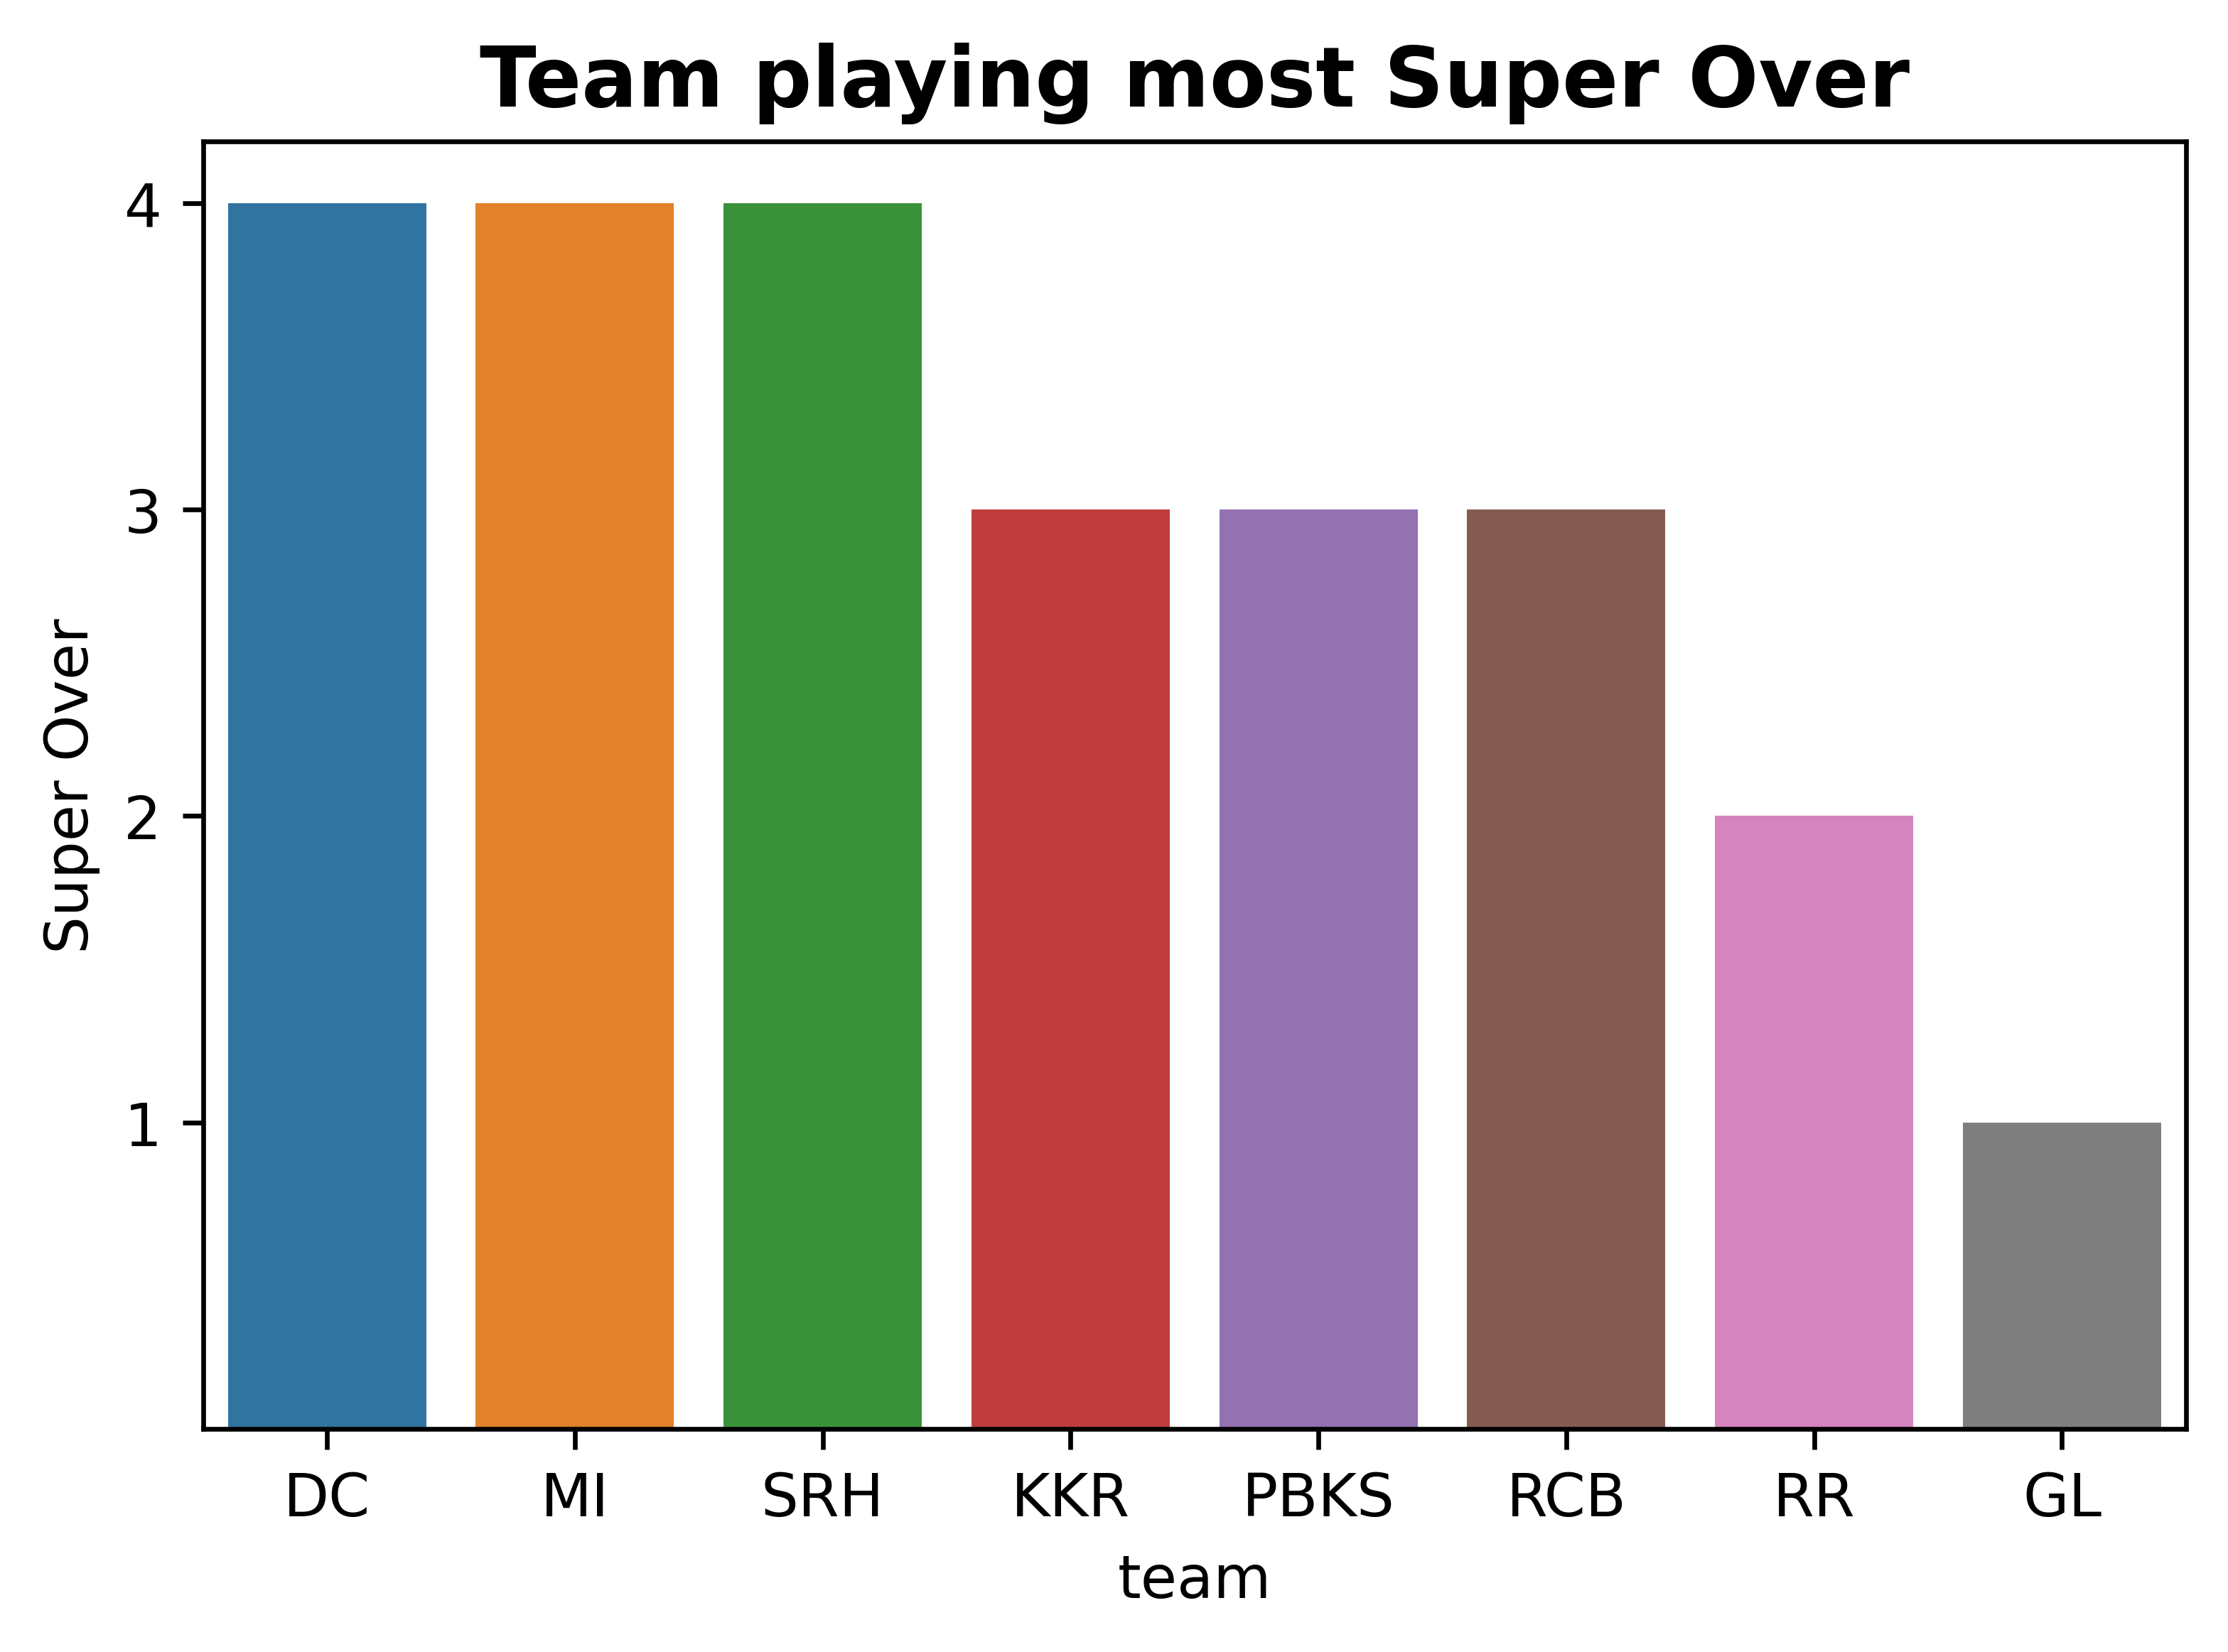

In [23]:
def super_over_team():
    super_over = season_summary_df[['super_over', 'home_team', 'away_team']].dropna()
    super_over['super_over'] = super_over['super_over'].astype(int)
    super_over = super_over[super_over['super_over'] == 1]
    super_over.reset_index(drop=True, inplace=True)
    super_over_1 = super_over[['super_over', 'away_team']]
    super_over_1.columns = ['super_over', 'team']
    super_over_2 = super_over[['super_over', 'home_team']]
    super_over_2.columns = ['super_over', 'team']
    super_over = pd.concat([super_over_1, super_over_2])
    super_over = super_over.groupby(['team']).sum().reset_index()
    super_over = super_over.sort_values(by='super_over', ascending=False)
    super_over = super_over.reset_index(drop=True)
    super_over['Super Over'] = super_over['super_over'].astype(int)
    sns.barplot(x='team', y='Super Over', data=super_over)
    plt.title("Team playing most Super Over", fontsize=14, fontweight='bold')
    plt.yticks([1,2,3,4])
    plt.show()

super_over_team()

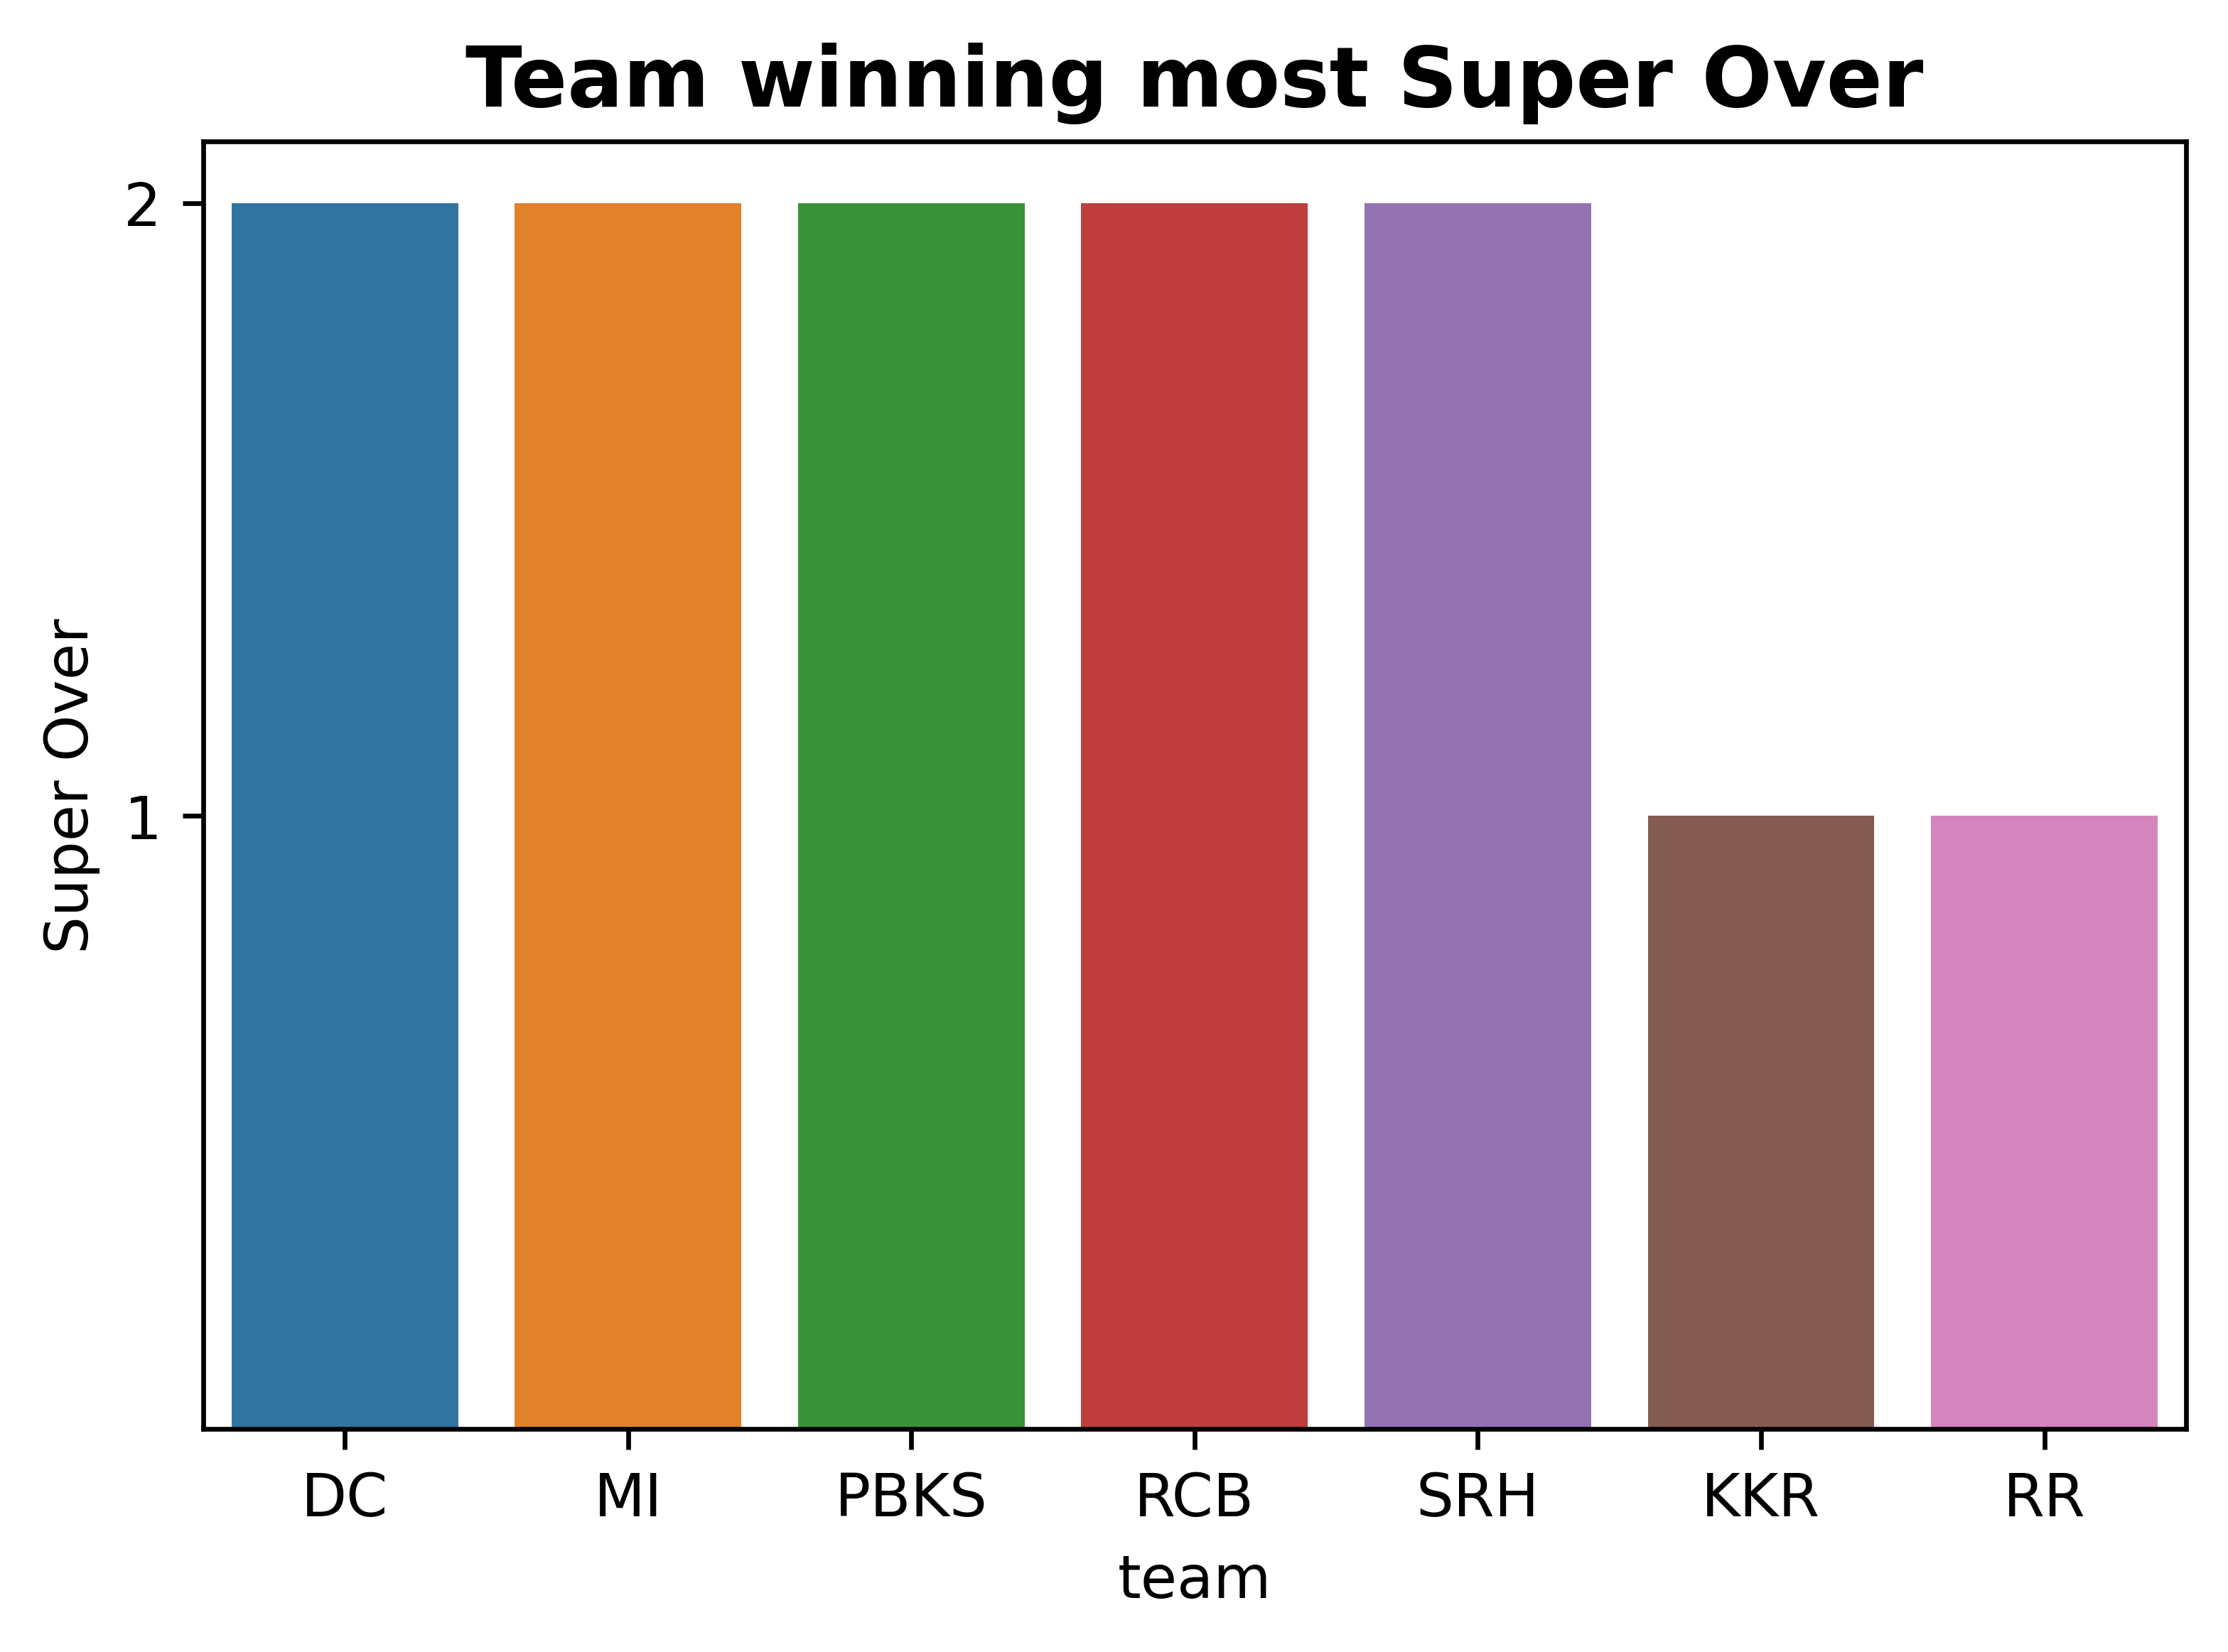

In [24]:
def super_over_win_team():
    super_over = season_summary_df[['super_over', 'winner']].dropna()
    super_over['super_over'] = super_over['super_over'].astype(int)
    super_over = super_over[super_over['super_over'] == 1]
    super_over.reset_index(drop=True, inplace=True)
    super_over.columns = ['super_over', 'team']
    super_over = super_over.groupby(['team']).sum().reset_index()
    super_over = super_over.sort_values(by='super_over', ascending=False)
    super_over = super_over.reset_index(drop=True)
    super_over['Super Over'] = super_over['super_over'].astype(int)
    sns.barplot(x='team', y='Super Over', data=super_over)
    plt.title("Team winning most Super Over", fontsize=14, fontweight='bold')
    plt.yticks([1,2])
    plt.show()

super_over_win_team()

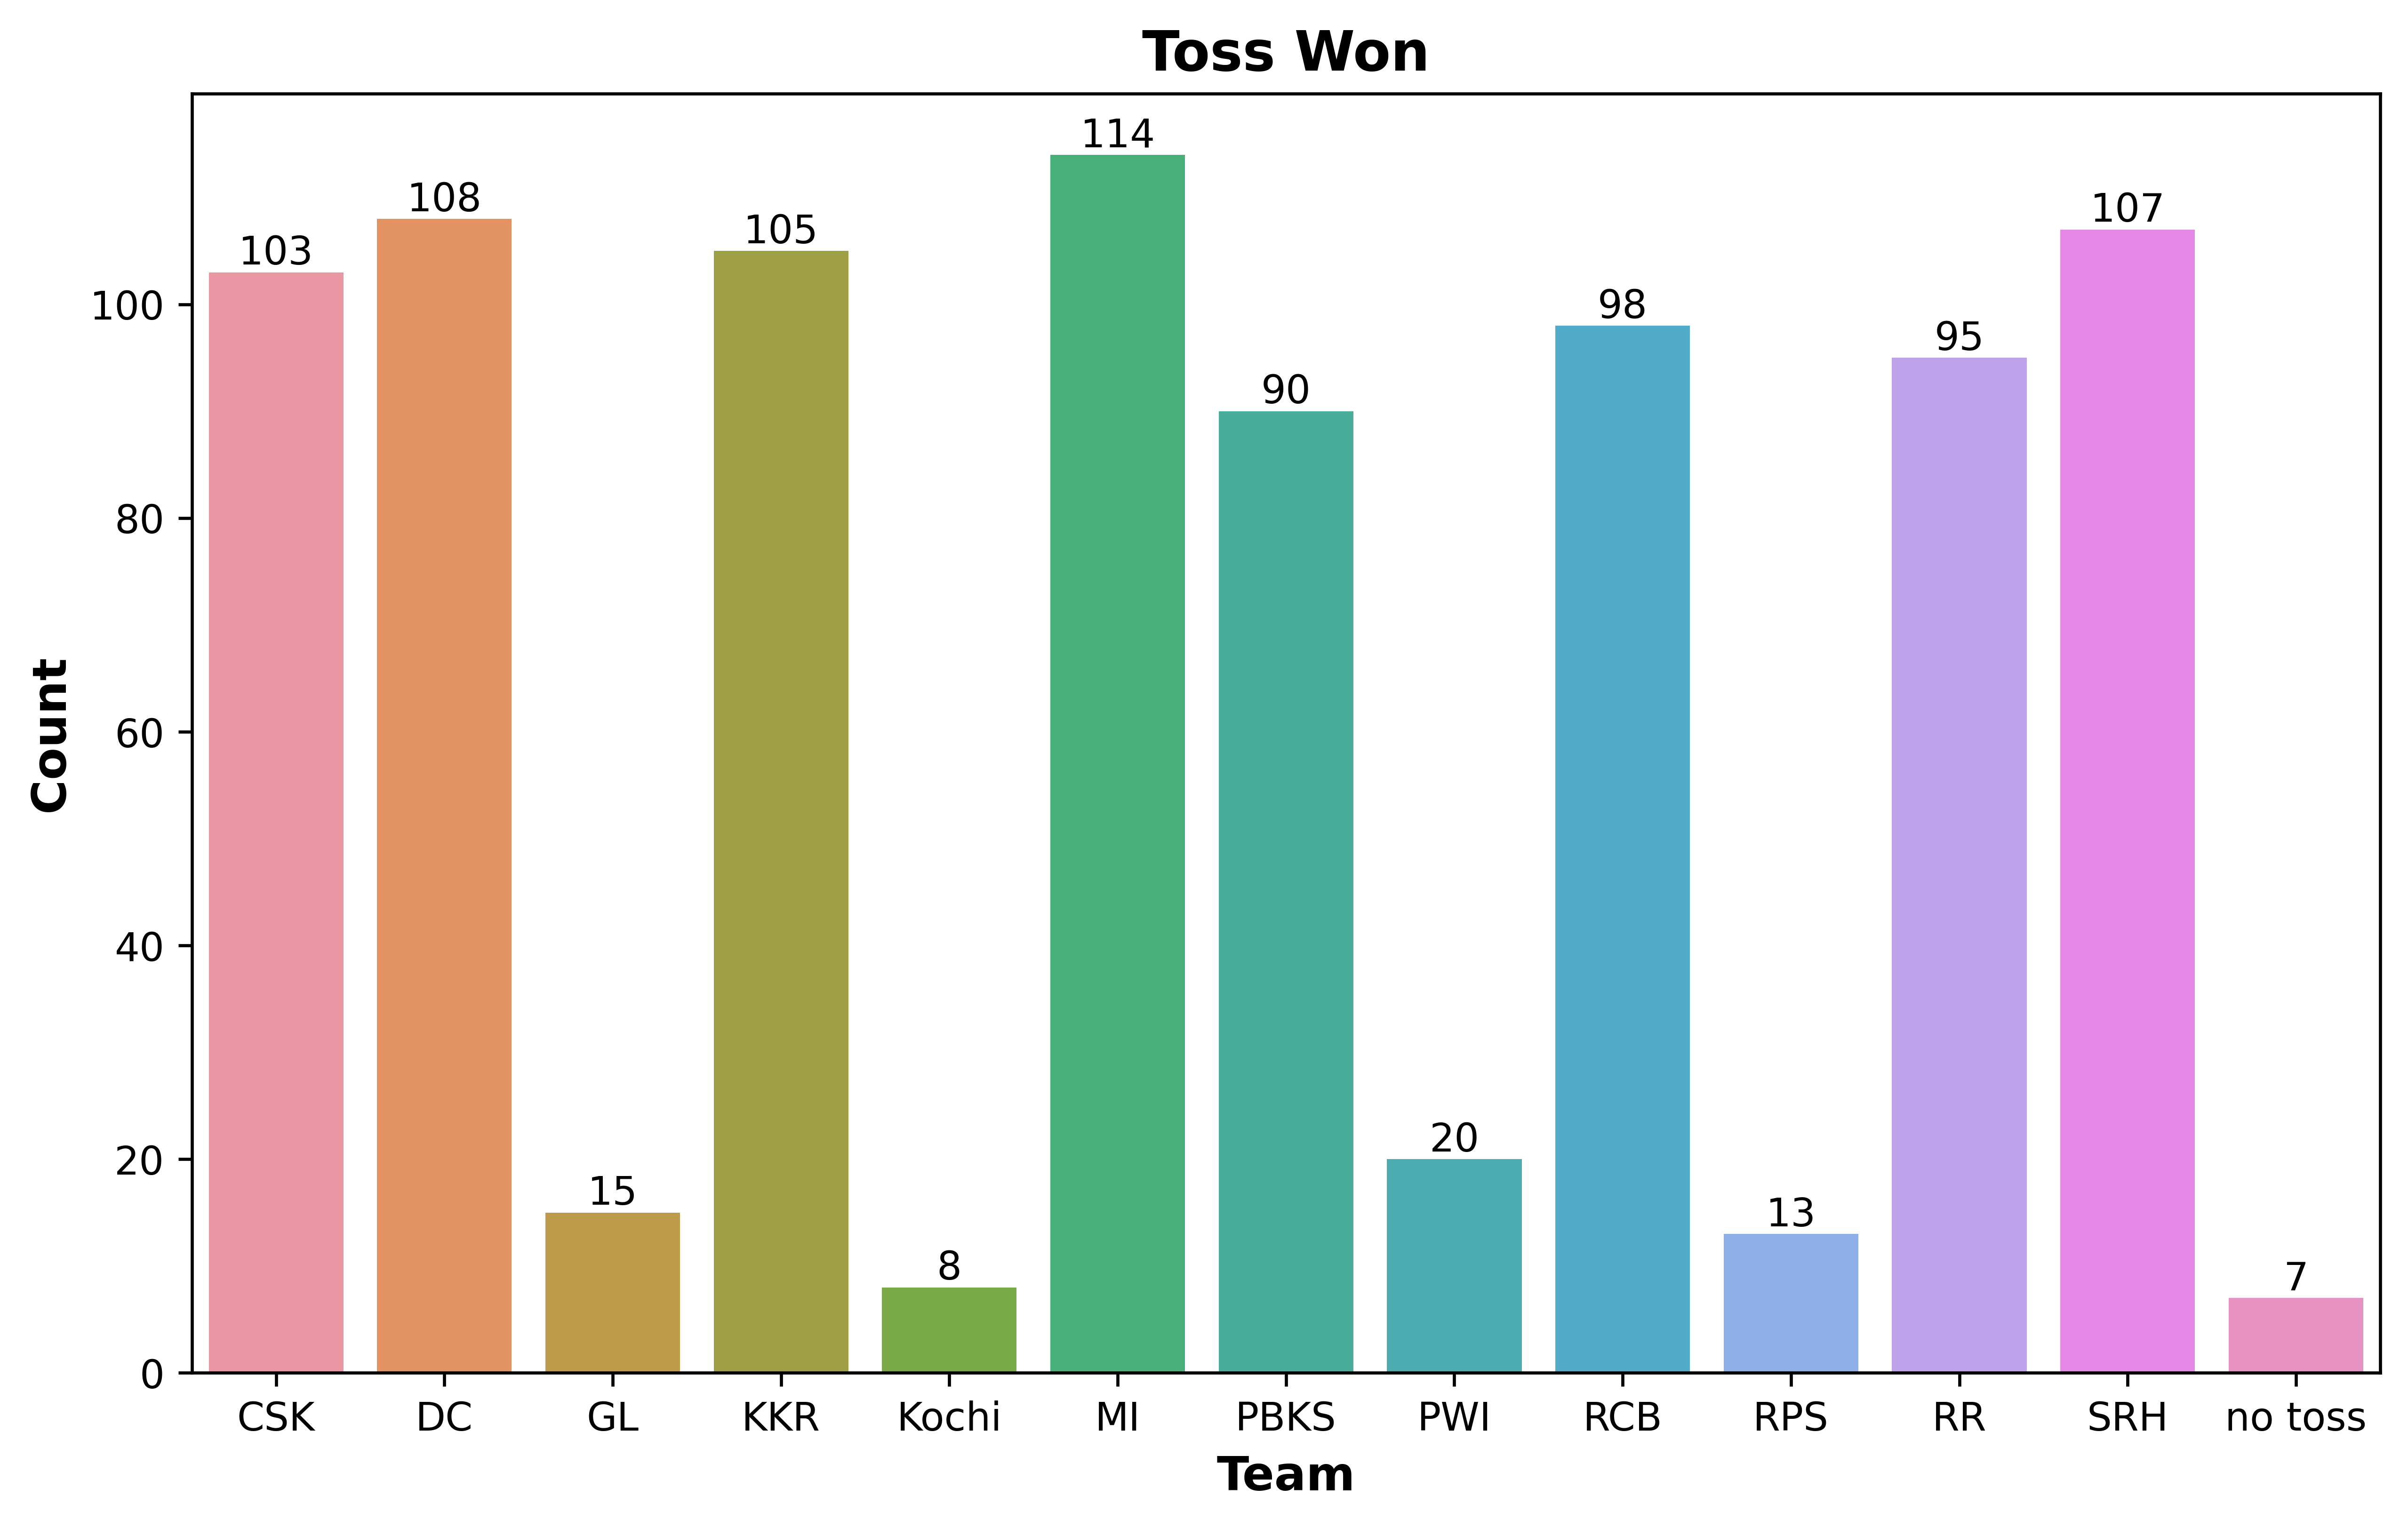

In [58]:
def toss_won_by_team():
    """
    Toss won by team
    """
    toss_df = season_summary_df['toss_won'].dropna()
    toss_df = toss_df.groupby(toss_df).count()
    toss_df =  toss_df.to_dict()
    toss_df_keys = list(toss_df.keys())
    toss_df_values = list(toss_df.values())
    ax = sns.barplot(x=toss_df_keys, y=toss_df_values)
    #set figure size to (10, 6)
    ax.figure.set_size_inches(10, 6)
    ax.set_title("Toss Won", fontsize=14, fontweight='bold')
    ax.set_xlabel("Team", fontsize=12, fontweight='bold')
    ax.set_ylabel("Count", fontsize=12, fontweight='bold')
    ax.bar_label(container=ax.containers[0])
toss_won_by_team()

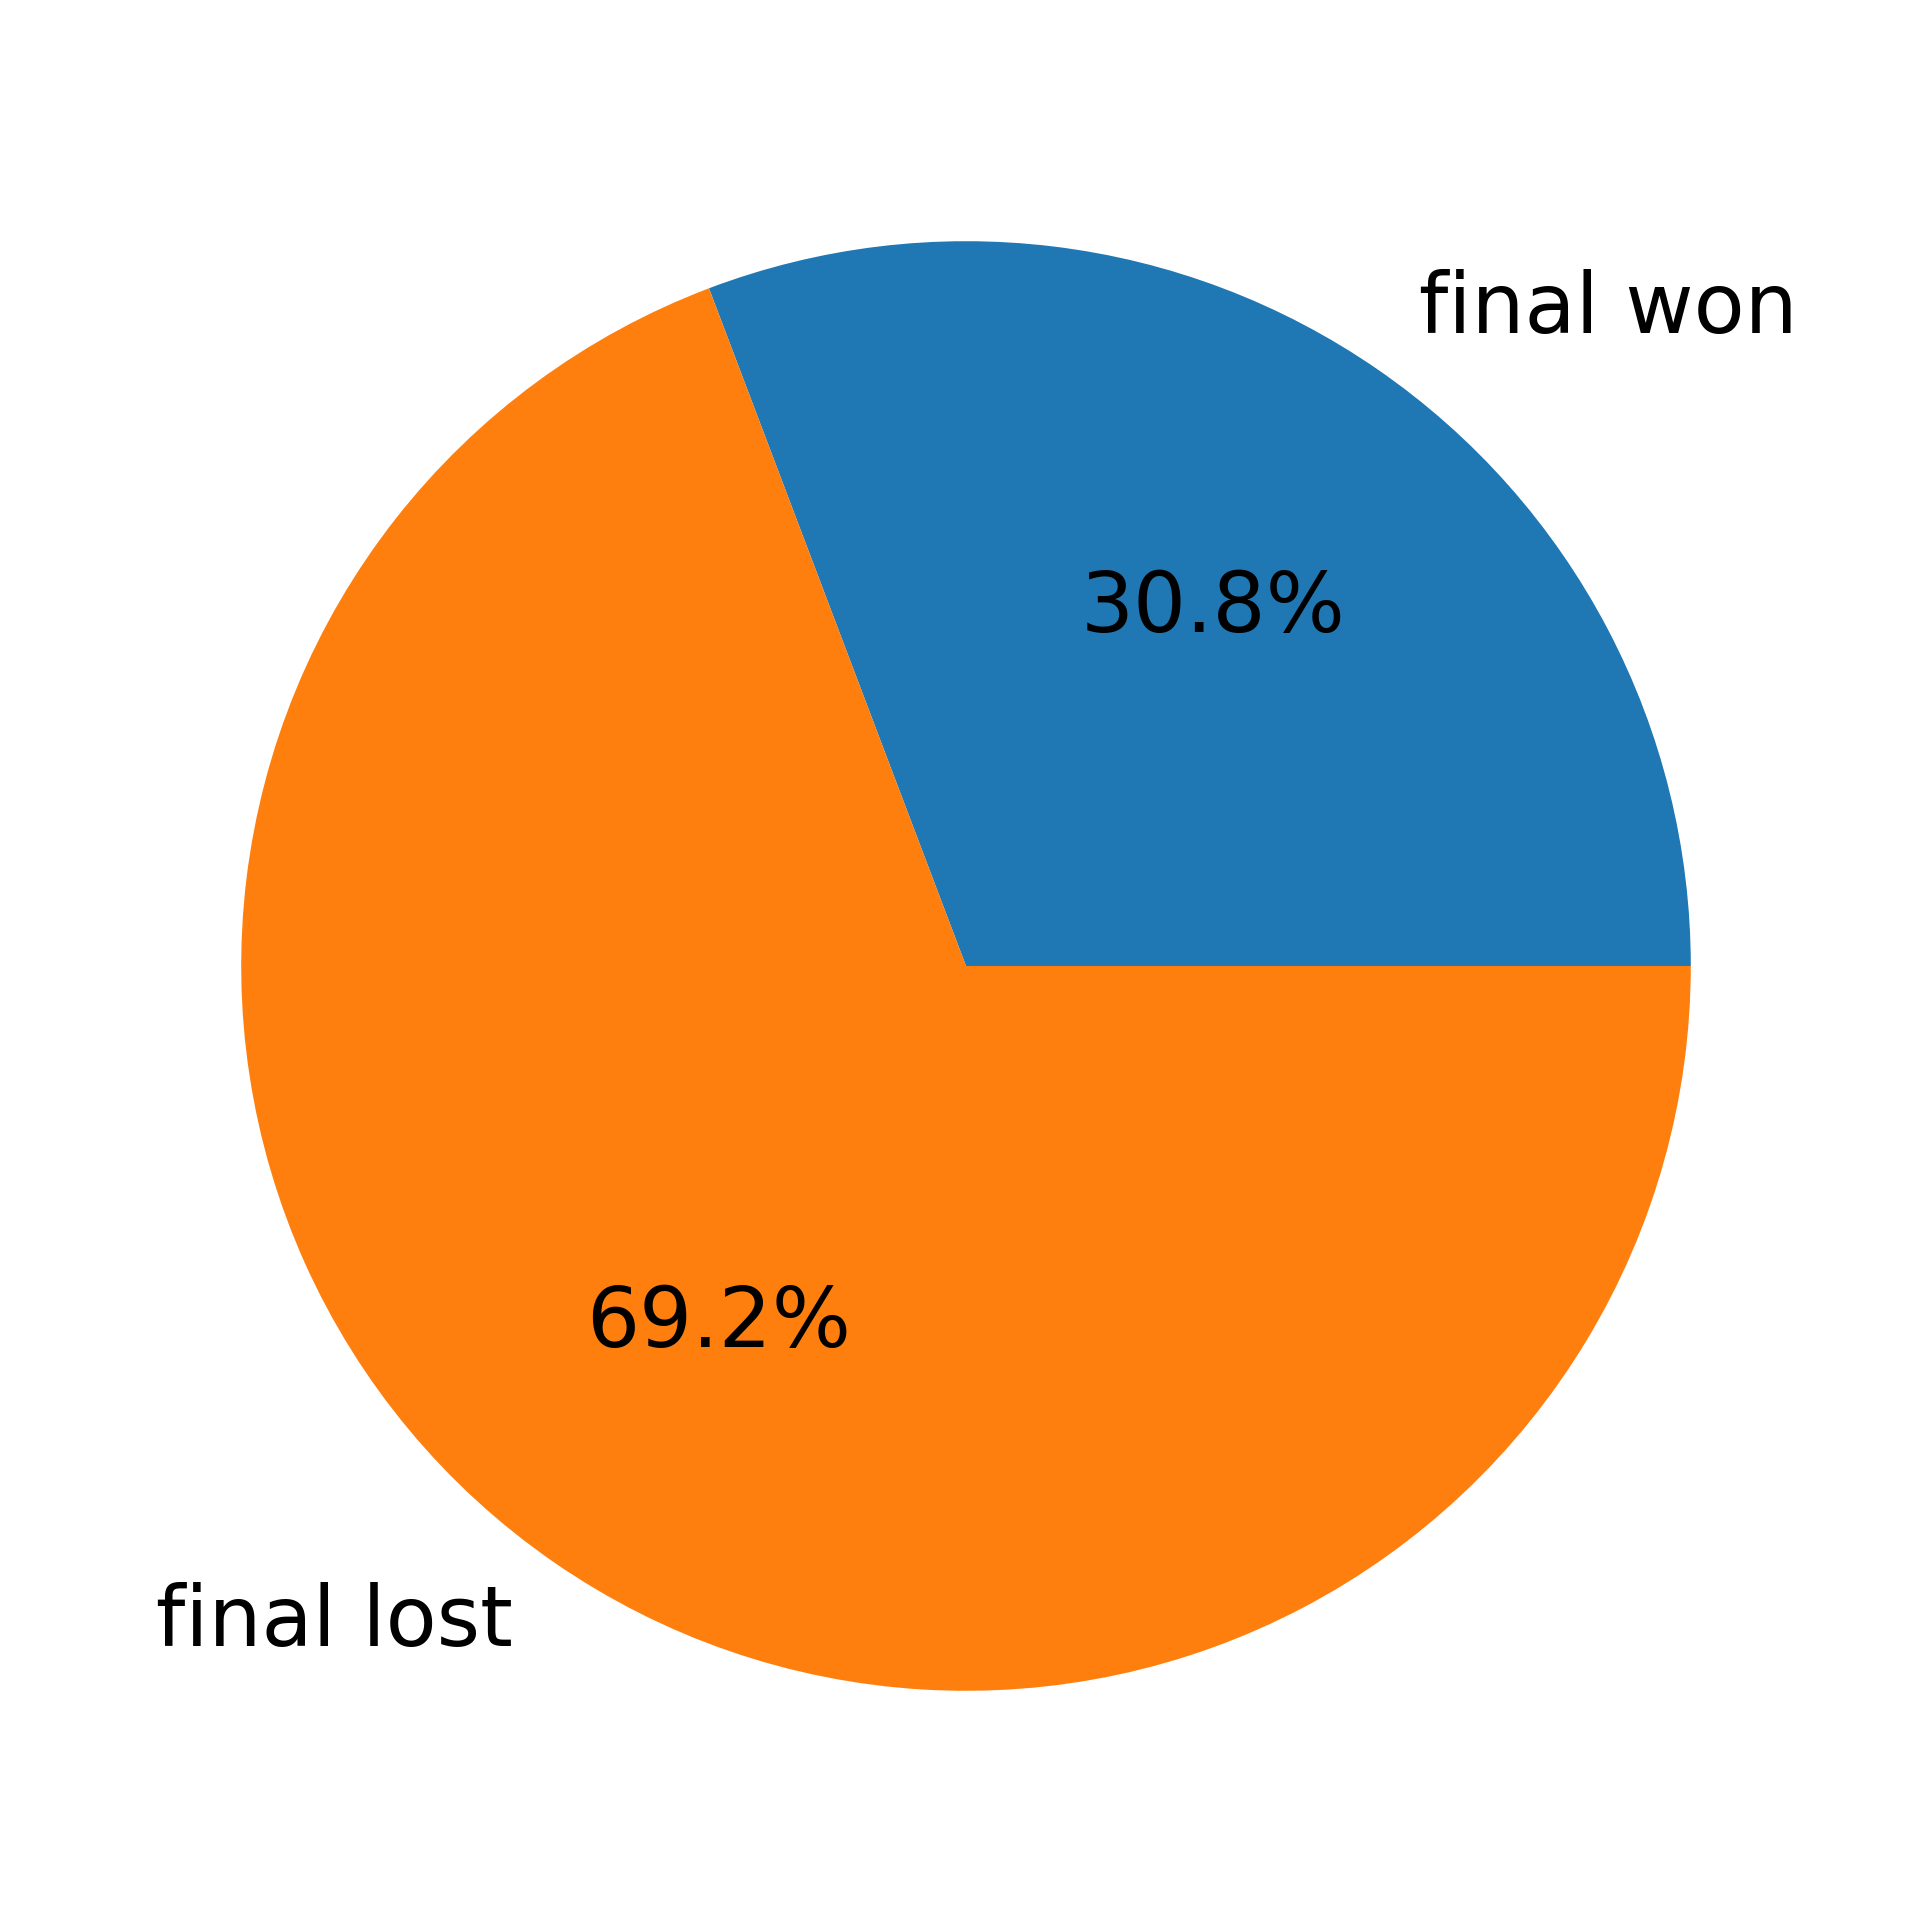

In [72]:
def final_win_toss_to_win():
    final_df = season_summary_df[['winner', 'toss_won', 'description']].dropna()
    final_df['stage'] = final_df['description'].apply(lambda x: x.split(',')[0].title().split(' ')[0])
    final_df = final_df[final_df['stage'] == 'Final']
    final_df['toss_won_to_won'] = final_df['winner'] == final_df['toss_won']
    final_df = final_df['toss_won_to_won'].dropna()
    final_df = final_df.groupby(final_df).count()
    final_df =  final_df.to_dict()
    final_df_keys = list(final_df.keys())
    final_df_values = list(final_df.values())
    plt.pie(final_df_values, labels=['final won', 'final lost'], autopct='%1.1f%%')
    plt.show()

final_win_toss_to_win()